In [8]:
import random
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")

In [10]:
# Load datasets from disk with transforms applied
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize for CNNs
    transforms.ToTensor()])

train_data = datasets.INaturalist(root='data/train_mini', version="2021_train_mini", transform=transform, download=False)

train_data_sample_indices = random.sample(range(len(train_data)), 10000)


imgs = torch.stack([train_data[i][0] for i in train_data_sample_indices], dim=3)
sample_mean = imgs.view(3, -1).mean(dim=1)
sample_std = imgs.view(3, -1).std(dim=1)

In [11]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize for CNNs
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=sample_mean, std=sample_std)
])

# Load datasets from disk with transforms applied
train_data = datasets.INaturalist(root='data/train_mini', version="2021_train_mini", transform=transform, download=False)
validation_data = datasets.INaturalist(root='data/validation', version="2021_valid", transform=transform, download=False)

# Create DataLoaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(validation_data, batch_size=32, shuffle=False, num_workers=4)

print(f"Training samples: {len(train_data)}")
print(f"Validation samples: {len(validation_data)}")

Training samples: 500000
Validation samples: 100000


In [12]:
cat_list = [int(cat[1:5]) for cat in train_data.all_categories if "Animalia_Chordata_Mammalia" in cat]
# get corresponding labels

In [13]:
# mammal_indices = []
# for i, (_, label) in enumerate(train_data):
#     print(i, label)
#     if label > 4858:
#         break
#     if label >= 4613 and label <= 4858:
#         mammal_indices.append(i)

In [14]:
# with open('mammal_indices.txt', 'w') as f:
#     for line in mammal_indices:
#         f.write(f"{line}\n")

In [21]:
mammal_indices = []
with open('mammal_indices.txt', 'r') as f:
    for line in f:
        mammal_indices.append(int(line[0:-1]))

In [43]:
mammal_val_indices = []
for i, (_, label) in enumerate(validation_data):
    print(i, label)
    if label > 4858:
        break
    if label >= 4613 and label <= 4858:
        mammal_val_indices.append(i)

0 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 1
11 1
12 1
13 1
14 1
15 1
16 1
17 1
18 1
19 1
20 2
21 2
22 2
23 2
24 2
25 2
26 2
27 2
28 2
29 2
30 3
31 3
32 3
33 3
34 3
35 3
36 3
37 3
38 3
39 3
40 4
41 4
42 4
43 4
44 4
45 4
46 4
47 4
48 4
49 4
50 5
51 5
52 5
53 5
54 5
55 5
56 5
57 5
58 5
59 5
60 6
61 6
62 6
63 6
64 6
65 6
66 6
67 6
68 6
69 6
70 7
71 7
72 7
73 7
74 7
75 7
76 7
77 7
78 7
79 7
80 8
81 8
82 8
83 8
84 8
85 8
86 8
87 8
88 8
89 8
90 9
91 9
92 9
93 9
94 9
95 9
96 9
97 9
98 9
99 9
100 10
101 10
102 10
103 10
104 10
105 10
106 10
107 10
108 10
109 10
110 11
111 11
112 11
113 11
114 11
115 11
116 11
117 11
118 11
119 11
120 12
121 12
122 12
123 12
124 12
125 12
126 12
127 12
128 12
129 12
130 13
131 13
132 13
133 13
134 13
135 13
136 13
137 13
138 13
139 13
140 14
141 14
142 14
143 14
144 14
145 14
146 14
147 14
148 14
149 14
150 15
151 15
152 15
153 15
154 15
155 15
156 15
157 15
158 15
159 15
160 16
161 16
162 16
163 16
164 16
165 16
166 16
167 16
168 16
169 16
170 17
171 17
172 17

In [44]:
with open('mammal_val_indices.txt', 'w') as f:
    for line in mammal_val_indices:
        f.write(f"{line}\n")

In [ ]:
mammal_val_indices = []
with open('mammal_val_indices.txt', 'r') as f:
    for line in f:
        mammal_val_indices.append(int(line[0:-1]))

In [48]:
from torch.utils.data import Subset

# Find all indices where the target (label) corresponds to mammals
# Create a subset dataset containing only mammals
train_data_mammals = Subset(train_data, mammal_indices)

# Create a DataLoader for the filtered dataset
train_loader_mammals = DataLoader(train_data_mammals, batch_size=128, shuffle=True, num_workers=4)

val_data_mammals = Subset(validation_data, mammal_val_indices)
val_loader_mammals = DataLoader(val_data_mammals, batch_size=128, shuffle=False, num_workers=4)

print(f"Filtered train dataset contains {len(train_data_mammals)} mammal images.")
print(f"Filtered val dataset contains {len(val_data_mammals)} mammal images.")

Filtered train dataset contains 12300 mammal images.
Filtered val dataset contains 2460 mammal images.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


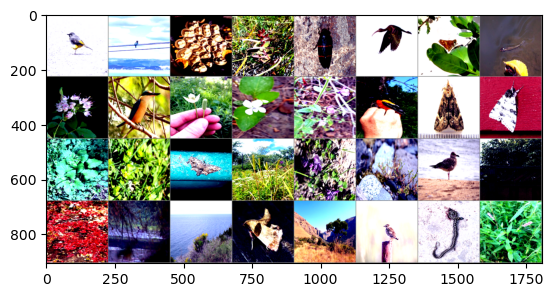

In [24]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(make_grid(images))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


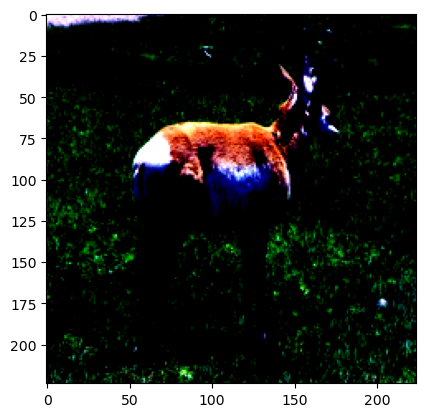

In [25]:
plt.imshow(train_data_mammals[1][0].permute(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


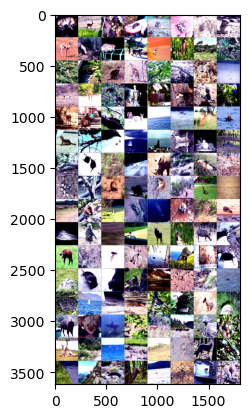

In [26]:
# get some random training images
dataiter = iter(train_loader_mammals)
images, labels = next(dataiter)

# show images
imshow(make_grid(images))

In [27]:
len(cat_list)

246

In [28]:
n_classes = len(cat_list)
n_classes

246

In [29]:
# Define a Simple CNN Model
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)

        # Pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers
        self.fc1 = nn.Linear(32 * 56 * 56, 128)  # 32 channels, 56x56 image size after pooling
        self.fc2 = nn.Linear(128, num_classes)   # Output layer
        
        # Dropout to prevent overfitting
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # Conv1 -> ReLU -> MaxPool
        x = self.pool(F.relu(self.conv2(x)))  # Conv2 -> ReLU -> MaxPool
        x = x.view(x.shape[0], -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)  # Output layer
        return x

In [30]:
def remap_labels(labels):
    return (labels - 4613).long()  # Convert labels to tensor and ensure they are Long type


def train_model(model, train_loader, criterion, optimizer, epochs=5):
    model.train()  # Set to training mode

    train_n = len(train_loader)
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            labels = remap_labels(labels).to(device)
            optimizer.zero_grad()  # Reset gradients
            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update weights

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
        # Print epoch stats
        print(f"Epoch {epoch+1}/{epochs} - Loss: {running_loss/len(train_loader):.4f} - Accuracy: {100 * correct / total:.2f}%")


In [ ]:
simple_cnn = SimpleCNN(num_classes=n_classes).to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(simple_cnn.parameters(), lr=0.003)

# Train the model
train_model(simple_cnn, train_loader_mammals, criterion, optimizer, epochs=200)

In [61]:
torch.cuda.empty_cache()

In [ ]:
# Define a Simple CNN Model
class SimpleCNN_2(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN_2, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, padding=1)

        # Pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2)

        # Fully connected layers
        self.fc1 = nn.Linear(16 * 56 * 56, 512)  # 16 channels, 56x56 image size after pooling
        self.fc2 = nn.Linear(512, num_classes)   # Output layer
        
        # Dropout to prevent overfitting
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # Conv1 -> ReLU -> MaxPool
        x = self.pool(F.relu(self.conv2(x)))  # Conv2 -> ReLU -> MaxPool
        x = x.view(x.shape[0], -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)  # Output layer
        return x

In [69]:
simple_cnn_2.parameters

<bound method Module.parameters of SimpleCNN_2(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=50176, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=246, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)>

In [63]:
simple_cnn_2 = SimpleCNN_2(num_classes=n_classes).to(device)

criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(simple_cnn_2.parameters(), lr=0.001)


# Train the model
train_model(simple_cnn_2, train_loader_mammals, criterion, optimizer, epochs=50)

Epoch 1/50 - Loss: 5.5878 - Accuracy: 0.34%
Epoch 2/50 - Loss: 5.4785 - Accuracy: 0.46%
Epoch 3/50 - Loss: 5.3930 - Accuracy: 1.09%
Epoch 4/50 - Loss: 5.2806 - Accuracy: 1.62%
Epoch 5/50 - Loss: 5.0738 - Accuracy: 2.82%
Epoch 6/50 - Loss: 4.7089 - Accuracy: 6.73%
Epoch 7/50 - Loss: 4.0411 - Accuracy: 15.26%
Epoch 8/50 - Loss: 3.1283 - Accuracy: 30.26%
Epoch 9/50 - Loss: 2.2026 - Accuracy: 47.59%
Epoch 10/50 - Loss: 1.5047 - Accuracy: 62.74%
Epoch 11/50 - Loss: 1.0404 - Accuracy: 73.80%
Epoch 12/50 - Loss: 0.8030 - Accuracy: 79.37%
Epoch 13/50 - Loss: 0.6107 - Accuracy: 84.19%
Epoch 14/50 - Loss: 0.4918 - Accuracy: 86.85%
Epoch 15/50 - Loss: 0.4328 - Accuracy: 88.34%
Epoch 16/50 - Loss: 0.3541 - Accuracy: 90.32%
Epoch 17/50 - Loss: 0.3404 - Accuracy: 90.80%
Epoch 18/50 - Loss: 0.3031 - Accuracy: 91.89%
Epoch 19/50 - Loss: 0.2744 - Accuracy: 92.44%
Epoch 20/50 - Loss: 0.2592 - Accuracy: 92.97%
Epoch 21/50 - Loss: 0.2373 - Accuracy: 93.36%
Epoch 22/50 - Loss: 0.2215 - Accuracy: 93.76%
Epo

In [86]:
torch.cuda.empty_cache()

In [83]:
# Define a Simple CNN Model
class SimpleCNN_3(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN_3, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=24, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=24, out_channels=16, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=8, kernel_size=3, padding=1)

        # Pooling layer
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.pool3 = nn.MaxPool2d(kernel_size=2)

        # Fully connected layers
        self.fc1 = nn.Linear(8 * 28 * 28, 512)  # 16 channels, 56x56 image size after pooling
        self.fc2 = nn.Linear(512, num_classes)   # Output layer
        
        # Dropout to prevent overfitting
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))  # Conv1 -> ReLU -> MaxPool
        x = self.pool2(F.relu(self.conv2(x)))  # Conv2 -> ReLU -> MaxPool
        x = self.pool3(F.relu(self.conv3(x)))  # Conv2 -> ReLU -> MaxPool
        x = x.view(x.shape[0], -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)  # Output layer
        return x

In [87]:
simple_cnn_3 = SimpleCNN_3(num_classes=n_classes).to(device)

criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(simple_cnn_3.parameters(), lr=0.001)


# Train the model
train_model(simple_cnn_3, train_loader_mammals, criterion, optimizer, epochs=25)

Epoch 1/25 - Loss: 5.5075 - Accuracy: 0.38%
Epoch 2/25 - Loss: 5.4550 - Accuracy: 0.79%
Epoch 3/25 - Loss: 5.2700 - Accuracy: 1.63%
Epoch 4/25 - Loss: 5.0134 - Accuracy: 4.48%
Epoch 5/25 - Loss: 4.4796 - Accuracy: 11.24%
Epoch 6/25 - Loss: 3.6352 - Accuracy: 24.11%
Epoch 7/25 - Loss: 2.7815 - Accuracy: 39.02%
Epoch 8/25 - Loss: 2.1015 - Accuracy: 52.60%
Epoch 9/25 - Loss: 1.6427 - Accuracy: 62.50%
Epoch 10/25 - Loss: 1.3430 - Accuracy: 69.17%
Epoch 11/25 - Loss: 1.1129 - Accuracy: 73.94%
Epoch 12/25 - Loss: 0.9969 - Accuracy: 76.93%
Epoch 13/25 - Loss: 0.8949 - Accuracy: 79.09%
Epoch 14/25 - Loss: 0.7658 - Accuracy: 81.80%
Epoch 15/25 - Loss: 0.7097 - Accuracy: 83.39%
Epoch 16/25 - Loss: 0.6167 - Accuracy: 85.67%
Epoch 17/25 - Loss: 0.5836 - Accuracy: 86.62%
Epoch 18/25 - Loss: 0.5496 - Accuracy: 87.59%
Epoch 19/25 - Loss: 0.4899 - Accuracy: 88.20%
Epoch 20/25 - Loss: 0.4630 - Accuracy: 89.28%
Epoch 21/25 - Loss: 0.4342 - Accuracy: 89.66%
Epoch 22/25 - Loss: 0.4161 - Accuracy: 90.20%
E

In [57]:
def evaluate_model(model, val_loader):
    model.eval()  # Set to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():  # No gradient computation for validation
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            labels = remap_labels(labels).to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    print(f"Validation Accuracy: {100 * correct / total:.2f}%")

In [64]:
# Run evaluation
evaluate_model(simple_cnn_2, val_loader_mammals)

Validation Accuracy: 1.95%


In [88]:
evaluate_model(simple_cnn_3, val_loader_mammals)

Validation Accuracy: 1.30%


In [ ]:
mammal_classes = [cat for cat in train_data.all_categories if "Animalia_Chordata_Mammalia" in cat]

In [68]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in mammal_classes}
total_pred = {classname: 0 for classname in mammal_classes}

# again no gradients needed
with torch.no_grad():
    for data in val_loader_mammals:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        labels = remap_labels(labels).to(device)
        outputs = simple_cnn_2(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[mammal_classes[label]] += 1
            total_pred[mammal_classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: 04613_Animalia_Chordata_Mammalia_Artiodactyla_Antilocapridae_Antilocapra_americana is 0.0 %
Accuracy for class: 04614_Animalia_Chordata_Mammalia_Artiodactyla_Balaenopteridae_Balaenoptera_acutorostrata is 10.0 %
Accuracy for class: 04615_Animalia_Chordata_Mammalia_Artiodactyla_Balaenopteridae_Megaptera_novaeangliae is 20.0 %
Accuracy for class: 04616_Animalia_Chordata_Mammalia_Artiodactyla_Bovidae_Aepyceros_melampus is 0.0 %
Accuracy for class: 04617_Animalia_Chordata_Mammalia_Artiodactyla_Bovidae_Alcelaphus_buselaphus is 0.0 %
Accuracy for class: 04618_Animalia_Chordata_Mammalia_Artiodactyla_Bovidae_Antidorcas_marsupialis is 0.0 %
Accuracy for class: 04619_Animalia_Chordata_Mammalia_Artiodactyla_Bovidae_Bison_bison is 0.0 %
Accuracy for class: 04620_Animalia_Chordata_Mammalia_Artiodactyla_Bovidae_Bos_taurus is 0.0 %
Accuracy for class: 04621_Animalia_Chordata_Mammalia_Artiodactyla_Bovidae_Boselaphus_tragocamelus is 0.0 %
Accuracy for class: 04622_Animalia_Chordata_M